https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

### ***About Dataset***

**Context** <br>

Although there have been lot of studies undertaken in the past on factors affecting life expectancy considering demographic variables, income composition and mortality rates. It was found that affect of immunization and human development index was not taken into account in the past. Also, some of the past research was done considering multiple linear regression based on data set of one year for all the countries. Hence, this gives motivation to resolve both the factors stated previously by formulating a regression model based on mixed effects model and multiple linear regression while considering data from a period of 2000 to 2015 for all the countries. Important immunization like Hepatitis B, Polio and Diphtheria will also be considered. In a nutshell, this study will focus on immunization factors, mortality factors, economic factors, social factors and other health related factors as well. Since the observations this dataset are based on different countries, it will be easier for a country to determine the predicting factor which is contributing to lower value of life expectancy. This will help in suggesting a country which area should be given importance in order to efficiently improve the life expectancy of its population.

**Content** <br>

The project relies on accuracy of data. The Global Health Observatory (GHO) data repository under World Health Organization (WHO) keeps track of the health status as well as many other related factors for all countries The data-sets are made available to public for the purpose of health data analysis. The data-set related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. Among all categories of health-related factors only those critical factors were chosen which are more representative. It has been observed that in the past 15 years , there has been a huge development in health sector resulting in improvement of human mortality rates especially in the developing nations in comparison to the past 30 years. Therefore, in this project we have considered data from year 2000-2015 for 193 countries for further analysis. The individual data files have been merged together into a single data-set. On initial visual inspection of the data showed some missing values. As the data-sets were from WHO, we found no evident errors. Missing data was handled in R software by using Missmap command. The result indicated that most of the missing data was for population, Hepatitis B and GDP. The missing data were from less known countries like Vanuatu, Tonga, Togo, Cabo Verde etc. Finding all data for these countries was difficult and hence, it was decided that we exclude these countries from the final model data-set. The final merged file(final dataset) consists of 22 Columns and 2938 rows which meant 20 predicting variables. All predicting variables was then divided into several broad categories: ​Immunization related factors, Mortality factors, Economical factors and Social factors.

**Acknowledgements** <br>

The data was collected from WHO and United Nations website with the help of Deeksha Russell and Duan Wang.

**Inspiration** <br>

*The data-set aims to answer the following key questions:*
1. Does various predicting factors which has been chosen initially really affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How does Infant and Adult mortality rates affect life expectancy?
4. Does Life Expectancy has positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life Expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of Immunization coverage on life Expectancy?

In [488]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import pingouin as pg
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### **Importing**, **cleaning** and **modeling**

In [185]:

df = pd.read_csv('./data/Life Expectancy Data.csv')
df.columns = [col.strip().replace('  ', ' ') for col in df.columns]
df = df.dropna(subset='Life expectancy').sort_values(by=['Country','Year']).rename(columns={'thinness 1-19 years':'thinness 10-19 years'})
df = df.drop('percentage expenditure', axis=1) # coluna com valores errados

# dados de continente e subcontinente tirados da API: https://restcountries.com/v3.1/name/{country}
df_region = pd.read_csv('./data/region_subregion_all_countries.csv')
df = pd.merge(df, df_region, on='Country', how='left')

# de acordo com o próprio WHO, os dados de população estam errados ~https://data.who.int/countries/
# dados corretos foram tirados das APIs: https://restcountries.com/v3.1/name/{country}, "http://api.worldbank.org/v2/country/{country}/indicator/SP.POP.TOTL" 
df_population = pd.read_csv('./data/population_2000_2015_all_countries.csv')
df = pd.merge(df.drop('Population', axis=1), df_population, on=['Country','Year'], how='left')
df['Population'] = df['Population']*10**6

# para as colunas "a cada 1k pessoas", se valor > 1k ~> valor = nulo
for col in ['Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']:
    df.loc[df[col] > 1000, col] = None

# fillna com a mediana dado mesmo ano e região ~ a ideia é que o valor perdido (nulo) seja parecido com os valores do mesmo ano e da mesma região.
for col in ['Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 'thinness 10-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']:
    for i in df[df[col].isna()].index:
        region = df.loc[i, 'region']
        year = df.loc[i, 'Year']

        values_region_year = df[(df['region'] == region) & (df['Year']==year) & (df[col].notna())][col]
        if not values_region_year.shape[0]:
            values_region_year = df[(df['region'] == region) & (df['Year']>=year-1) & (df['Year']<=year+1) & (df[col].notna())][col]
            
        df.loc[i, col] = values_region_year.median()

df = df[[
    'Year', 'Country', 'region', 'subregion', 'Status', 'Population', 'Income composition of resources', 'Schooling', 'Alcohol', 'GDP', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years',
    'Total expenditure', 'Hepatitis B', 'Polio', 'Diphtheria', 'Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles', 'Life expectancy'
]].copy()

display(df)
display(df.sample().iloc[0])

,Year,Country,region,subregion,Status,Population,Income composition of resources,Schooling,Alcohol,GDP,...,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
0,2000,Afghanistan,Asia,Southern Asia,Developing,20130000.0,0.338,5.5,0.01,114.560000,...,8.20,62.0,24.0,24.0,321.0,88.0,122.0,0.1,48.0,54.8
1,2001,Afghanistan,Asia,Southern Asia,Developing,20280000.0,0.340,5.9,0.01,117.496980,...,7.80,63.0,35.0,33.0,316.0,88.0,122.0,0.1,32.5,55.3
2,2002,Afghanistan,Asia,Southern Asia,Developing,21380000.0,0.341,6.2,0.01,187.845950,...,7.76,64.0,36.0,36.0,3.0,88.0,122.0,0.1,35.0,56.2
3,2003,Afghanistan,Asia,Southern Asia,Developing,22730000.0,0.373,6.5,0.01,198.728544,...,8.82,65.0,41.0,41.0,295.0,87.0,122.0,0.1,798.0,56.7
4,2004,Afghanistan,Asia,Southern Asia,Developing,23560000.0,0.381,6.8,0.02,219.141353,...,8.79,67.0,5.0,5.0,293.0,87.0,120.0,0.1,466.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2011,Zimbabwe,Africa,Southern Africa,Developing,13600000.0,0.452,10.1,6.00,839.927936,...,6.31,94.0,93.0,93.0,464.0,28.0,42.0,13.3,0.0,54.9
2924,2012,Zimbabwe,Africa,Southern Africa,Developing,13820000.0,0.464,9.8,6.09,955.648466,...,6.69,97.0,95.0,95.0,429.0,26.0,39.0,8.8,0.0,56.6
2925,2013,Zimbabwe,Africa,Southern Africa,Developing,14010000.0,0.488,10.4,6.39,111.227396,...,6.88,95.0,95.0,95.0,399.0,25.0,36.0,6.8,0.0,58.0
2926,2014,Zimbabwe,Africa,Southern Africa,Developing,14210000.0,0.498,10.3,6.50,127.474620,...,6.44,91.0,92.0,91.0,371.0,23.0,34.0,6.3,0.0,59.2


Year                                        2007
Country                                  Uruguay
region                                  Americas
subregion                          South America
Status                                Developing
Population                             3300000.0
Income composition of resources             0.76
Schooling                                   15.3
Alcohol                                     6.67
GDP                                     79.69746
BMI                                         59.5
thinness 10-19 years                         1.6
thinness 5-9 years                           1.5
Total expenditure                           8.23
Hepatitis B                                 94.0
Polio                                       94.0
Diphtheria                                  94.0
Adult Mortality                            124.0
infant deaths                                1.0
under-five deaths                            1.0
HIV/AIDS            

### **EDA**

In [186]:

print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

display(df.describe())

(2928, 23)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
Year,int64,0,0.0,16,"[2000, 2001, 2002]"
Country,object,0,0.0,183,"[Afghanistan, Albania, Algeria]"
region,object,0,0.0,5,"[Asia, Europe, Africa]"
subregion,object,0,0.0,24,"[Southern Asia, Southeast Europe, Northern Afr..."
Status,object,0,0.0,2,"[Developing, Developed]"
Population,float64,0,0.0,1807,"[20130000.0, 20280000.0, 21380000.0]"
Income composition of resources,float64,0,0.0,664,"[0.338, 0.34, 0.341]"
Schooling,float64,0,0.0,196,"[5.5, 5.9, 6.2]"
Alcohol,float64,0,0.0,1077,"[0.01, 0.02, 0.03]"
GDP,float64,0,0.0,2538,"[114.56, 117.49698, 187.84595]"


,Year,Population,Income composition of resources,Schooling,Alcohol,GDP,BMI,thinness 10-19 years,thinness 5-9 years,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
count,2928.00000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,3.657920e+07,0.627663,12.002391,4.514810,6817.864517,38.042657,4.879337,4.908811,5.940331,82.394980,82.552937,82.326673,164.796448,24.025273,32.473019,1.747712,80.686475,69.224932
std,4.61056,1.371552e+08,0.208368,3.305709,4.009847,13310.302935,19.936234,4.405439,4.492878,2.409215,22.869488,23.360891,23.650226,124.292079,67.508220,87.347243,5.085542,171.399037,9.523867
min,2000.00000,5.000000e+04,0.000000,0.000000,0.010000,1.681350,1.000000,0.100000,0.100000,0.370000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.100000,0.000000,36.300000
25%,2003.75000,2.110000e+06,0.491000,10.100000,0.867500,517.856585,19.200000,1.600000,1.600000,4.360000,81.000000,78.000000,78.000000,74.000000,0.000000,0.000000,0.100000,0.000000,63.100000
50%,2007.50000,8.160000e+06,0.677000,12.300000,3.675000,1820.702189,43.000000,3.400000,3.400000,5.760000,91.000000,93.000000,93.000000,144.000000,3.000000,4.000000,0.100000,10.000000,72.100000
75%,2011.25000,2.509250e+07,0.780000,14.300000,7.490000,5475.094150,56.100000,7.200000,7.300000,7.452500,96.000000,97.000000,97.000000,228.000000,22.000000,28.000000,0.800000,62.000000,75.700000
max,2015.00000,1.388000e+09,0.948000,20.700000,17.870000,119172.741800,77.600000,27.700000,28.600000,17.600000,99.000000,99.000000,99.000000,723.000000,1000.000000,943.000000,50.600000,999.000000,89.000000


#### *Univariate* Analysis

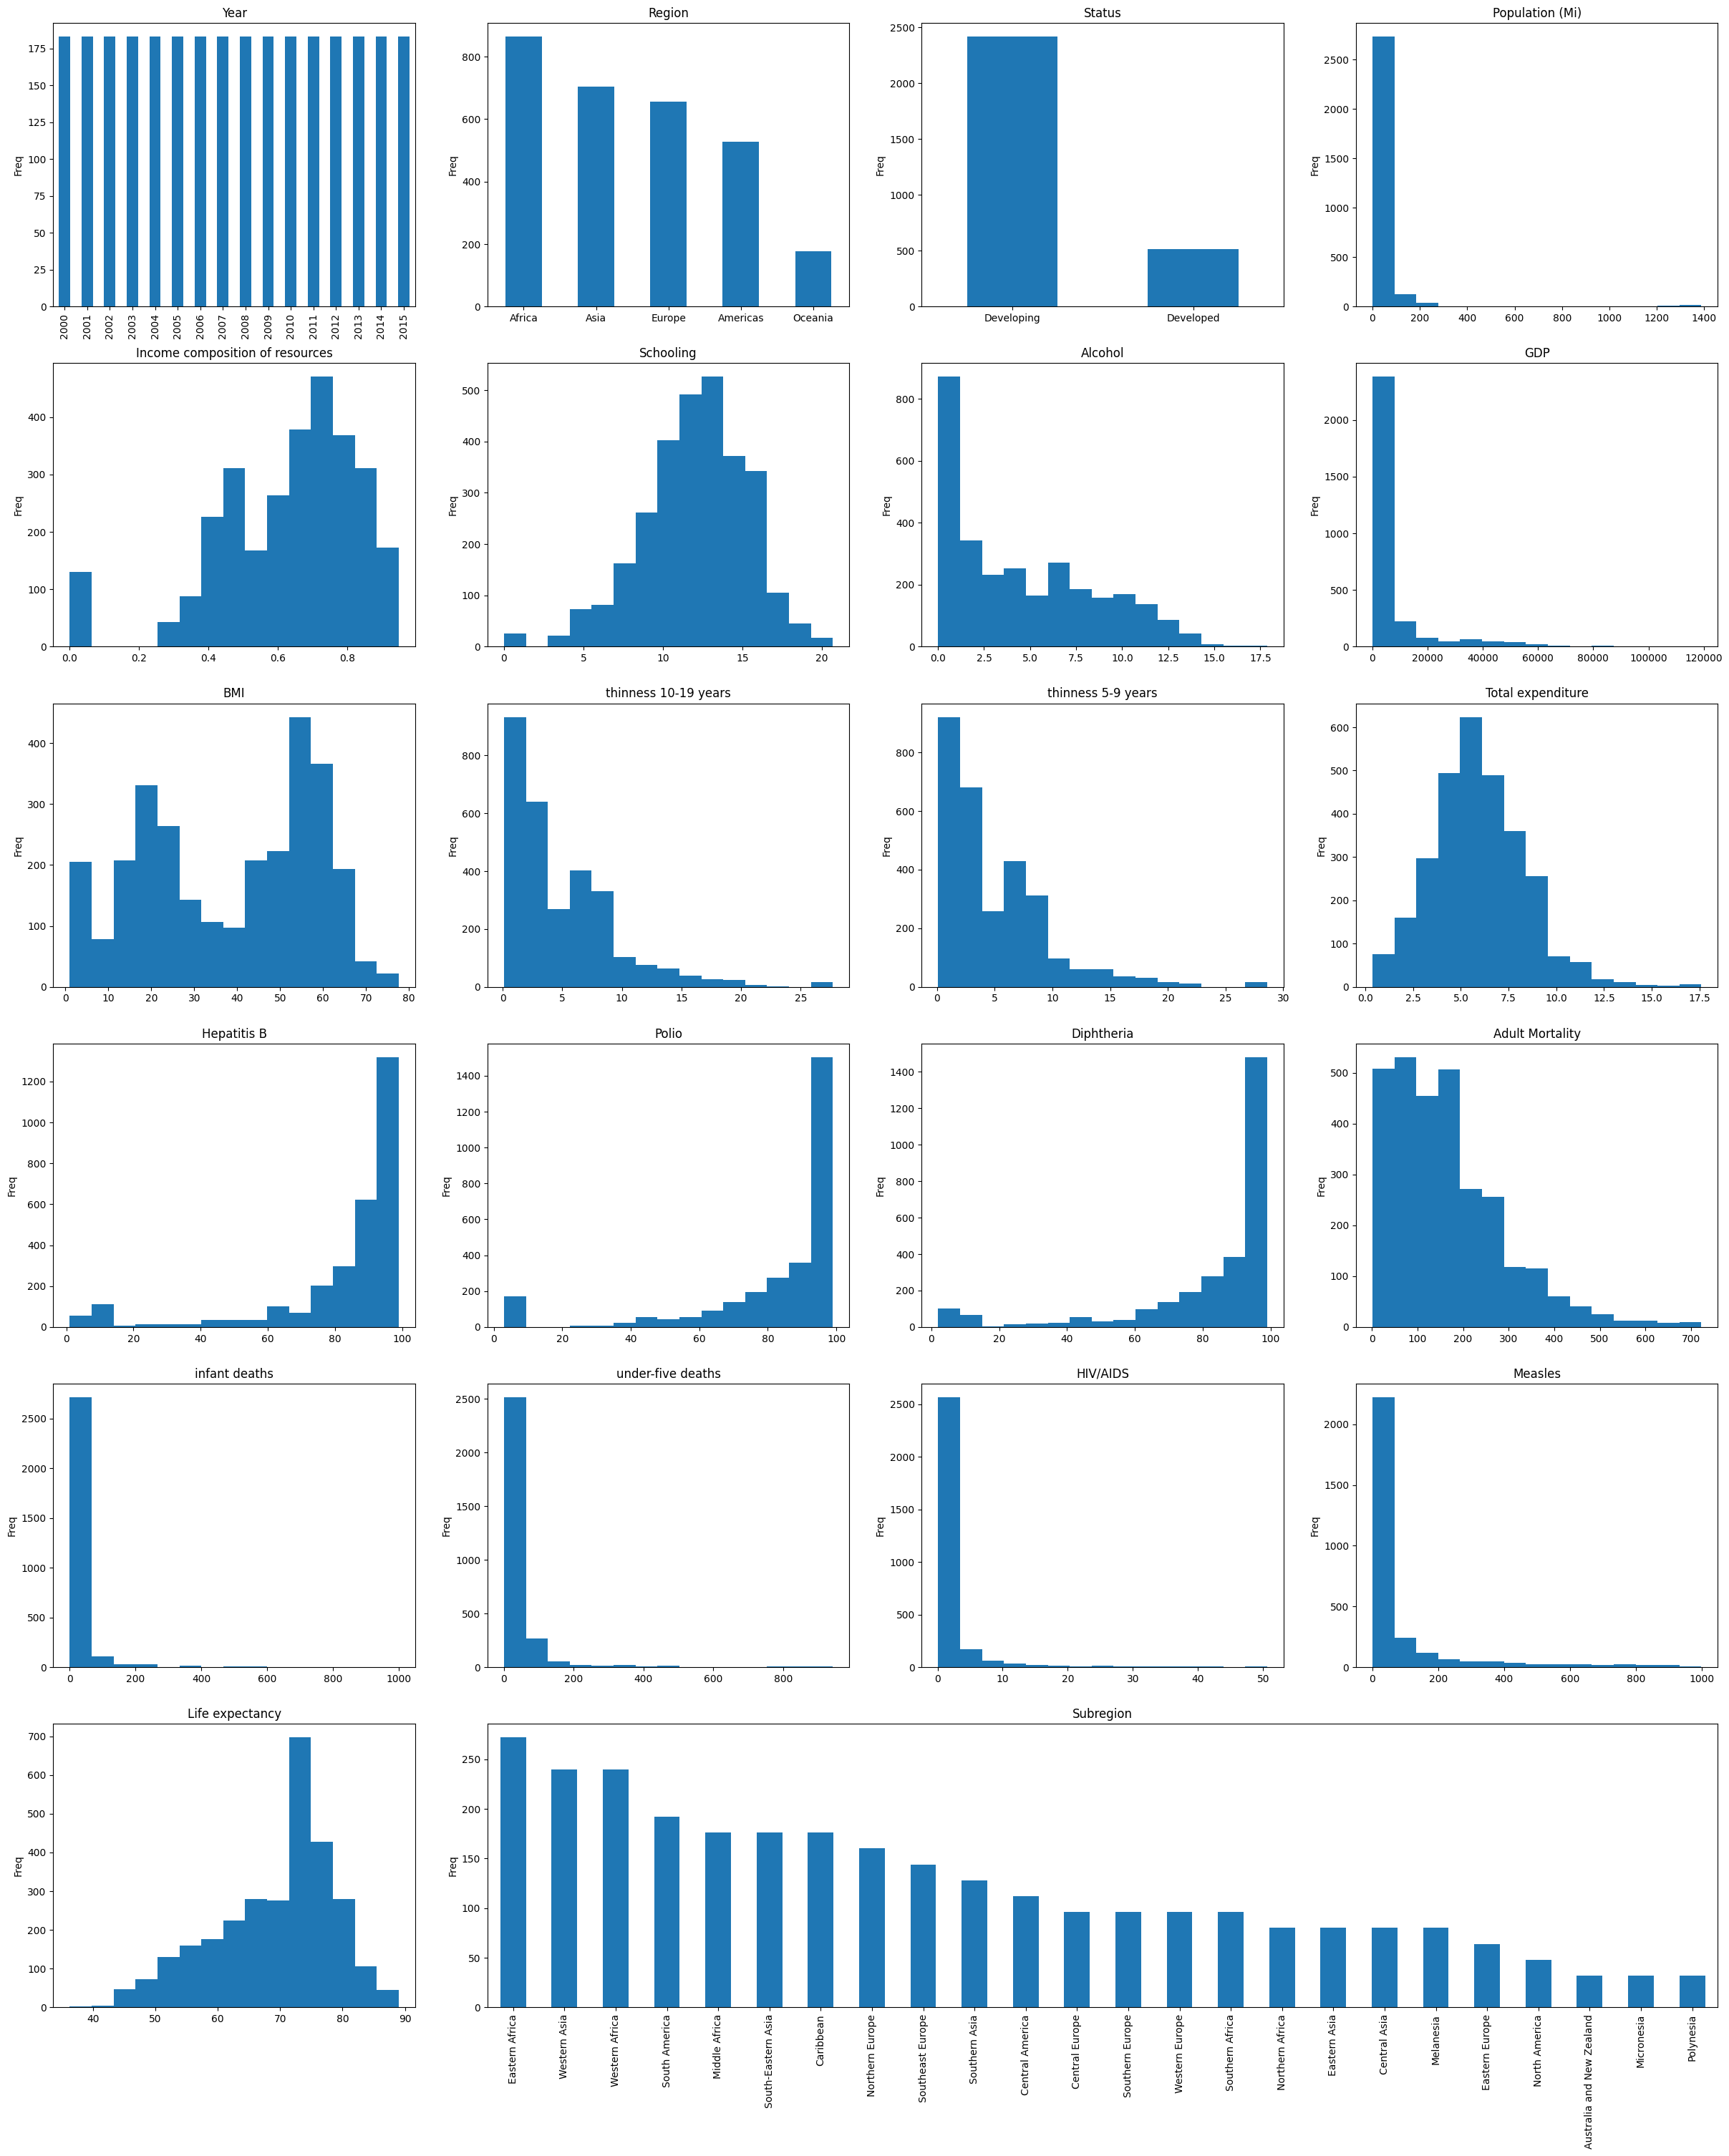

,Year,Population,Income composition of resources,Schooling,Alcohol,GDP,BMI,thinness 10-19 years,thinness 5-9 years,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
count,2928.00000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,3.657920e+07,0.627663,12.002391,4.514810,6817.864517,38.042657,4.879337,4.908811,5.940331,82.394980,82.552937,82.326673,164.796448,24.025273,32.473019,1.747712,80.686475,69.224932
std,4.61056,1.371552e+08,0.208368,3.305709,4.009847,13310.302935,19.936234,4.405439,4.492878,2.409215,22.869488,23.360891,23.650226,124.292079,67.508220,87.347243,5.085542,171.399037,9.523867
min,2000.00000,5.000000e+04,0.000000,0.000000,0.010000,1.681350,1.000000,0.100000,0.100000,0.370000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.100000,0.000000,36.300000
25%,2003.75000,2.110000e+06,0.491000,10.100000,0.867500,517.856585,19.200000,1.600000,1.600000,4.360000,81.000000,78.000000,78.000000,74.000000,0.000000,0.000000,0.100000,0.000000,63.100000
50%,2007.50000,8.160000e+06,0.677000,12.300000,3.675000,1820.702189,43.000000,3.400000,3.400000,5.760000,91.000000,93.000000,93.000000,144.000000,3.000000,4.000000,0.100000,10.000000,72.100000
75%,2011.25000,2.509250e+07,0.780000,14.300000,7.490000,5475.094150,56.100000,7.200000,7.300000,7.452500,96.000000,97.000000,97.000000,228.000000,22.000000,28.000000,0.800000,62.000000,75.700000
max,2015.00000,1.388000e+09,0.948000,20.700000,17.870000,119172.741800,77.600000,27.700000,28.600000,17.600000,99.000000,99.000000,99.000000,723.000000,1000.000000,943.000000,50.600000,999.000000,89.000000


In [197]:

fig = plt.figure(figsize=(30, 6*6))
grid = gridspec.GridSpec(6, 4, figure=fig)

# 1° linha
ax1 = fig.add_subplot(grid[0, 0])
df['Year'].value_counts().plot.bar(ax=ax1)
ax1.set_title('Year')
ax1.set_xlabel(None)
ax1.set_ylabel('Freq')

ax2 = fig.add_subplot(grid[0, 1])
df['region'].value_counts().plot.bar(ax=ax2)
ax2.set_title('Region')
ax2.set_xlabel(None)
ax2.set_ylabel('Freq')
ax2.tick_params(axis='x', labelrotation=0)

ax3 = fig.add_subplot(grid[0, 2])
df['Status'].value_counts().plot.bar(ax=ax3)
ax3.set_title('Status')
ax3.set_xlabel(None)
ax3.set_ylabel('Freq')
ax3.tick_params(axis='x', labelrotation=0)

ax4 = fig.add_subplot(grid[0, 3])
(df['Population']/(10**6)).plot.hist(ax=ax4, bins=15)
ax4.set_title('Population (Mi)')
ax4.set_xlabel(None)
ax4.set_ylabel('Freq')

# 2° linha
ax5 = fig.add_subplot(grid[1, 0])
df['Income composition of resources'].plot.hist(ax=ax5, bins=15)
ax5.set_title('Income composition of resources')
ax5.set_xlabel(None)
ax5.set_ylabel('Freq')

ax6 = fig.add_subplot(grid[1, 1])
df['Schooling'].plot.hist(ax=ax6, bins=15)
ax6.set_title('Schooling')
ax6.set_xlabel(None)
ax6.set_ylabel('Freq')

ax7 = fig.add_subplot(grid[1, 2])
df['Alcohol'].plot.hist(ax=ax7, bins=15)
ax7.set_title('Alcohol')
ax7.set_xlabel(None)
ax7.set_ylabel('Freq')

ax8 = fig.add_subplot(grid[1, 3])
df['GDP'].plot.hist(ax=ax8, bins=15)
ax8.set_title('GDP')
ax8.set_xlabel(None)
ax8.set_ylabel('Freq')

# 3° linha
ax9 = fig.add_subplot(grid[2, 0])
df['BMI'].plot.hist(ax=ax9, bins=15)
ax9.set_title('BMI')
ax9.set_xlabel(None)
ax9.set_ylabel('Freq')

ax10 = fig.add_subplot(grid[2, 1])
df['thinness 10-19 years'].plot.hist(ax=ax10, bins=15)
ax10.set_title('thinness 10-19 years')
ax10.set_xlabel(None)
ax10.set_ylabel('Freq')

ax11 = fig.add_subplot(grid[2, 2])
df['thinness 5-9 years'].plot.hist(ax=ax11, bins=15)
ax11.set_title('thinness 5-9 years')
ax11.set_xlabel(None)
ax11.set_ylabel('Freq')

ax12 = fig.add_subplot(grid[2, 3])
df['Total expenditure'].plot.hist(ax=ax12, bins=15)
ax12.set_title('Total expenditure')
ax12.set_xlabel(None)
ax12.set_ylabel('Freq')

# 4° linha
ax13 = fig.add_subplot(grid[3, 0])
df['Hepatitis B'].plot.hist(ax=ax13, bins=15)
ax13.set_title('Hepatitis B')
ax13.set_xlabel(None)
ax13.set_ylabel('Freq')

ax14 = fig.add_subplot(grid[3, 1])
df['Polio'].plot.hist(ax=ax14, bins=15)
ax14.set_title('Polio')
ax14.set_xlabel(None)
ax14.set_ylabel('Freq')

ax15 = fig.add_subplot(grid[3, 2])
df['Diphtheria'].plot.hist(ax=ax15, bins=15)
ax15.set_title('Diphtheria')
ax15.set_xlabel(None)
ax15.set_ylabel('Freq')

ax16 = fig.add_subplot(grid[3, 3])
df['Adult Mortality'].plot.hist(ax=ax16, bins=15)
ax16.set_title('Adult Mortality')
ax16.set_xlabel(None)
ax16.set_ylabel('Freq')

# 5° linha
ax17 = fig.add_subplot(grid[4, 0])
df['infant deaths'].plot.hist(ax=ax17, bins=15)
ax17.set_title('infant deaths')
ax17.set_xlabel(None)
ax17.set_ylabel('Freq')

ax18 = fig.add_subplot(grid[4, 1])
df['under-five deaths'].plot.hist(ax=ax18, bins=15)
ax18.set_title('under-five deaths')
ax18.set_xlabel(None)
ax18.set_ylabel('Freq')

ax19 = fig.add_subplot(grid[4, 2])
df['HIV/AIDS'].plot.hist(ax=ax19, bins=15)
ax19.set_title('HIV/AIDS')
ax19.set_xlabel(None)
ax19.set_ylabel('Freq')

ax20 = fig.add_subplot(grid[4, 3])
df['Measles'].plot.hist(ax=ax20, bins=15)
ax20.set_title('Measles')
ax20.set_xlabel(None)
ax20.set_ylabel('Freq')

# ultima linha
ax21 = fig.add_subplot(grid[5, 0])
df['Life expectancy'].plot.hist(ax=ax21, bins=15)
ax21.set_title('Life expectancy')
ax21.set_xlabel(None)
ax21.set_ylabel('Freq')

ax22 = fig.add_subplot(grid[5, 1:])
df['subregion'].value_counts().plot.bar(ax=ax22)
ax22.set_title('Subregion')
ax22.set_xlabel(None)
ax22.set_ylabel('Freq')

plt.show()

display(df.describe())

### *Bivariate* Analysis ~ versus **Life Expectancy**

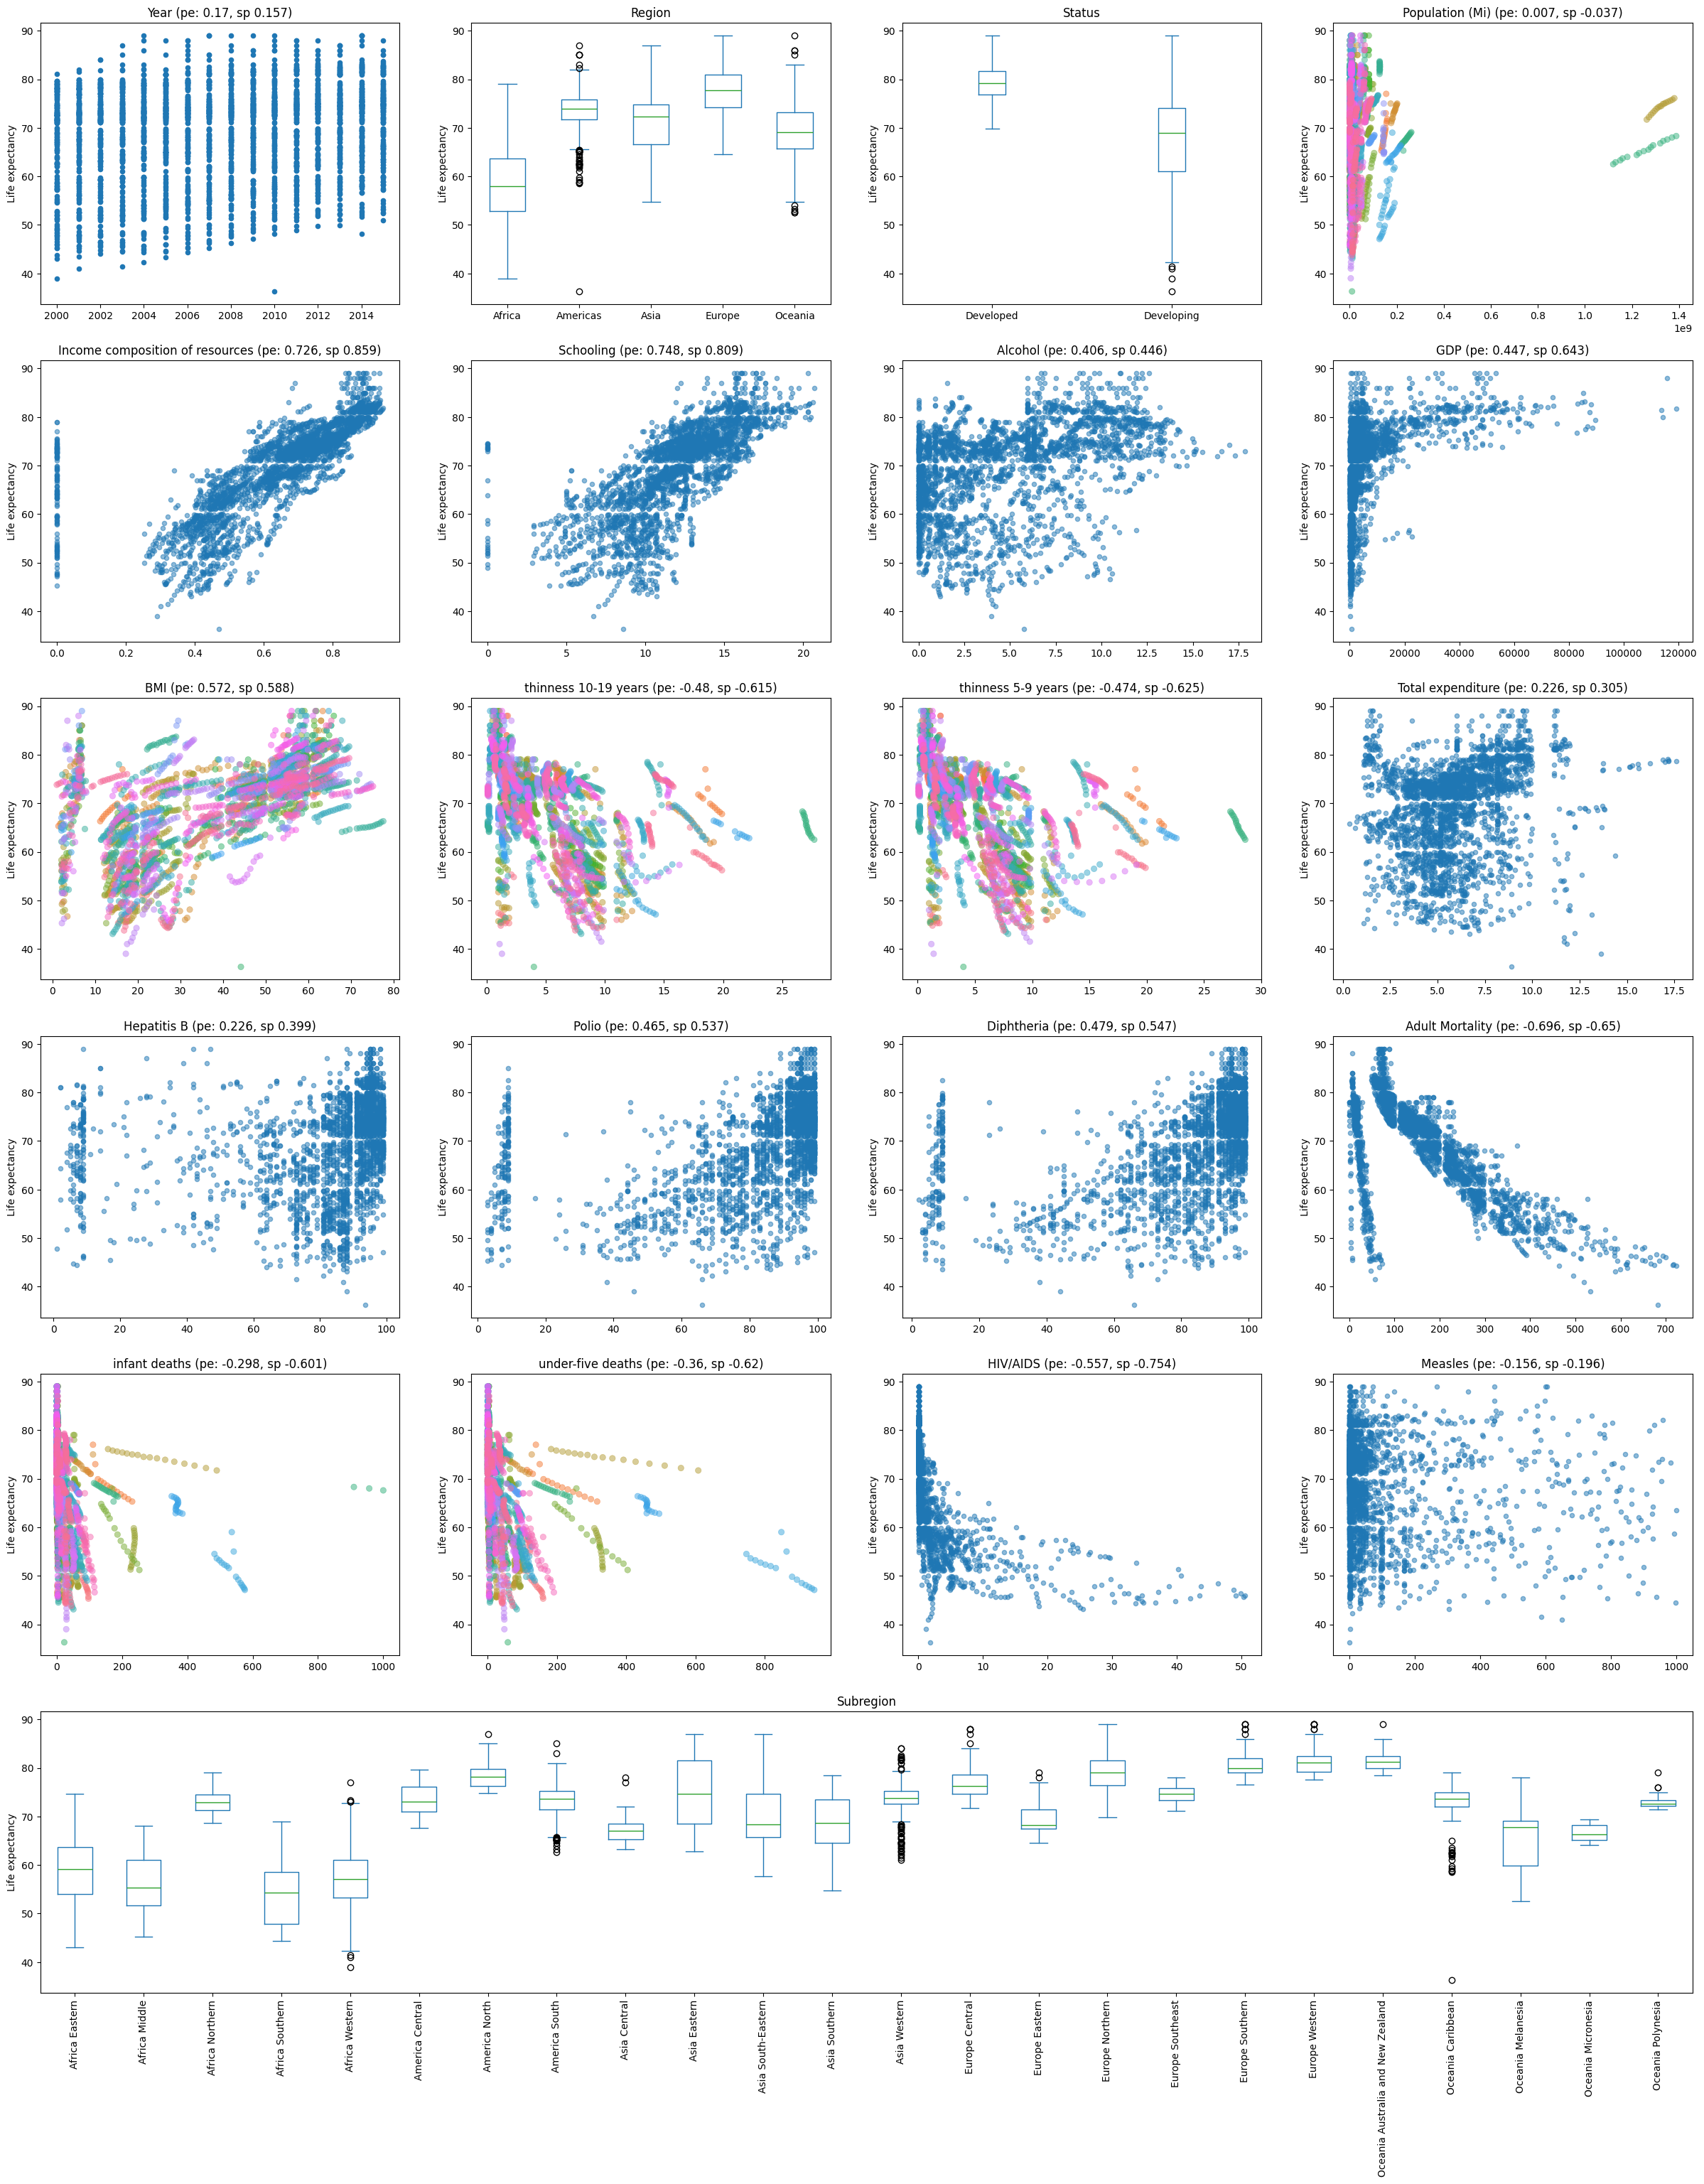

In [ ]:

fig = plt.figure(figsize=(30, 6*6))
grid = gridspec.GridSpec(6, 4, figure=fig)

# 1° linha
ax1 = fig.add_subplot(grid[0, 0])
df[['Year','Life expectancy']].plot.scatter(x='Year', y='Life expectancy', ax=ax1)
pearson_corr, _ = stats.pearsonr(df['Year'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Year'], df['Life expectancy'])
ax1.set_title(f'Year (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax1.set_xlabel(None)
ax1.set_ylabel('Life expectancy')

ax2 = fig.add_subplot(grid[0, 1])
df[['region','Life expectancy']].plot.box(by='region', ax=ax2)
ax2.set_title('Region')
ax2.set_xlabel(None)
ax2.set_ylabel('Life expectancy')

ax3 = fig.add_subplot(grid[0, 2])
df[['Status','Life expectancy']].plot.box(by='Status', ax=ax3)
ax3.set_title('Status')
ax3.set_xlabel(None)
ax3.set_ylabel('Life expectancy')

ax4 = fig.add_subplot(grid[0, 3])
# df[['Population','Life expectancy']].plot.scatter(x='Population', y='Life expectancy', alpha=.5, ax=ax4)
sns.scatterplot(x='Population', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax4)
ax4.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['Population'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Population'], df['Life expectancy'])
ax4.set_title(f'Population (Mi) (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax4.set_xlabel(None)
ax4.set_ylabel('Life expectancy')

# 2° linha
ax5 = fig.add_subplot(grid[1, 0])
df[['Income composition of resources','Life expectancy']].plot.scatter(x='Income composition of resources', y='Life expectancy', alpha=.5, ax=ax5)
pearson_corr, _ = stats.pearsonr(df['Income composition of resources'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Income composition of resources'], df['Life expectancy'])
ax5.set_title(f'Income composition of resources (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax5.set_xlabel(None)
ax5.set_ylabel('Life expectancy')

ax6 = fig.add_subplot(grid[1, 1])
df[['Schooling','Life expectancy']].plot.scatter(x='Schooling', y='Life expectancy', alpha=.5, ax=ax6)
pearson_corr, _ = stats.pearsonr(df['Schooling'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Schooling'], df['Life expectancy'])
ax6.set_title(f'Schooling (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax6.set_xlabel(None)
ax6.set_ylabel('Life expectancy')

ax7 = fig.add_subplot(grid[1, 2])
df[['Alcohol','Life expectancy']].plot.scatter(x='Alcohol', y='Life expectancy', alpha=.5, ax=ax7)
pearson_corr, _ = stats.pearsonr(df['Alcohol'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Alcohol'], df['Life expectancy'])
ax7.set_title(f'Alcohol (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax7.set_xlabel(None)
ax7.set_ylabel('Life expectancy')

ax8 = fig.add_subplot(grid[1, 3])
df[['GDP','Life expectancy']].plot.scatter(x='GDP', y='Life expectancy', alpha=.5, ax=ax8)
pearson_corr, _ = stats.pearsonr(df['GDP'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['GDP'], df['Life expectancy'])
ax8.set_title(f'GDP (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax8.set_xlabel(None)
ax8.set_ylabel('Life expectancy')

# 3° linha
ax9 = fig.add_subplot(grid[2, 0])
# df[['BMI','Life expectancy']].plot.scatter(x='BMI', y='Life expectancy', alpha=.5, ax=ax9)
sns.scatterplot(x='BMI', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax9)
ax9.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['BMI'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['BMI'], df['Life expectancy'])
ax9.set_title(f'BMI (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax9.set_xlabel(None)
ax9.set_ylabel('Life expectancy')

ax10 = fig.add_subplot(grid[2, 1])
# df[['thinness 10-19 years','Life expectancy']].plot.scatter(x='thinness 10-19 years', y='Life expectancy', alpha=.5, ax=ax10)
sns.scatterplot(x='thinness 10-19 years', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax10)
ax10.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['thinness 10-19 years'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['thinness 10-19 years'], df['Life expectancy'])
ax10.set_title(f'thinness 10-19 years (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax10.set_xlabel(None)
ax10.set_ylabel('Life expectancy')

ax11 = fig.add_subplot(grid[2, 2])
# df[['thinness 5-9 years','Life expectancy']].plot.scatter(x='thinness 5-9 years', y='Life expectancy', alpha=.5, ax=ax11)
sns.scatterplot(x='thinness 5-9 years', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax11)
ax11.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['thinness 5-9 years'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['thinness 5-9 years'], df['Life expectancy'])
ax11.set_title(f'thinness 5-9 years (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax11.set_xlabel(None)
ax11.set_ylabel('Life expectancy')

ax12 = fig.add_subplot(grid[2, 3])
df[['Total expenditure','Life expectancy']].plot.scatter(x='Total expenditure', y='Life expectancy', alpha=.5, ax=ax12)
pearson_corr, _ = stats.pearsonr(df['Total expenditure'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Total expenditure'], df['Life expectancy'])
ax12.set_title(f'Total expenditure (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax12.set_xlabel(None)
ax12.set_ylabel('Life expectancy')

# 4° linha
ax13 = fig.add_subplot(grid[3, 0])
df[['Hepatitis B','Life expectancy']].plot.scatter(x='Hepatitis B', y='Life expectancy', alpha=.5, ax=ax13)
pearson_corr, _ = stats.pearsonr(df['Hepatitis B'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Hepatitis B'], df['Life expectancy'])
ax13.set_title(f'Hepatitis B (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax13.set_xlabel(None)
ax13.set_ylabel('Life expectancy')

ax14 = fig.add_subplot(grid[3, 1])
df[['Polio','Life expectancy']].plot.scatter(x='Polio', y='Life expectancy', alpha=.5, ax=ax14)
pearson_corr, _ = stats.pearsonr(df['Polio'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Polio'], df['Life expectancy'])
ax14.set_title(f'Polio (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax14.set_xlabel(None)
ax14.set_ylabel('Life expectancy')

ax15 = fig.add_subplot(grid[3, 2])
df[['Diphtheria','Life expectancy']].plot.scatter(x='Diphtheria', y='Life expectancy', alpha=.5, ax=ax15)
pearson_corr, _ = stats.pearsonr(df['Diphtheria'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Diphtheria'], df['Life expectancy'])
ax15.set_title(f'Diphtheria (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax15.set_xlabel(None)
ax15.set_ylabel('Life expectancy')

ax16 = fig.add_subplot(grid[3, 3])
df[['Adult Mortality','Life expectancy']].plot.scatter(x='Adult Mortality', y='Life expectancy', alpha=.5, ax=ax16)
pearson_corr, _ = stats.pearsonr(df['Adult Mortality'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Adult Mortality'], df['Life expectancy'])
ax16.set_title(f'Adult Mortality (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax16.set_xlabel(None)
ax16.set_ylabel('Life expectancy')

# 5° linha
ax17 = fig.add_subplot(grid[4, 0])
# df[['infant deaths','Life expectancy']].plot.scatter(x='infant deaths', y='Life expectancy', alpha=.5, ax=ax17)
sns.scatterplot(x='infant deaths', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax17)
ax17.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['infant deaths'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['infant deaths'], df['Life expectancy'])
ax17.set_title(f'infant deaths (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax17.set_xlabel(None)
ax17.set_ylabel('Life expectancy')

ax18 = fig.add_subplot(grid[4, 1])
# df[['under-five deaths','Life expectancy']].plot.scatter(x='under-five deaths', y='Life expectancy', alpha=.5, ax=ax18)
sns.scatterplot(x='under-five deaths', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax18)
ax18.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['under-five deaths'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['under-five deaths'], df['Life expectancy'])
ax18.set_title(f'under-five deaths (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax18.set_xlabel(None)
ax18.set_ylabel('Life expectancy')

ax19 = fig.add_subplot(grid[4, 2])
df[['HIV/AIDS','Life expectancy']].plot.scatter(x='HIV/AIDS', y='Life expectancy', alpha=.5, ax=ax19)
pearson_corr, _ = stats.pearsonr(df['HIV/AIDS'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['HIV/AIDS'], df['Life expectancy'])
ax19.set_title(f'HIV/AIDS (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax19.set_xlabel(None)
ax19.set_ylabel('Life expectancy')

ax20 = fig.add_subplot(grid[4, 3])
df[['Measles','Life expectancy']].plot.scatter(x='Measles', y='Life expectancy', alpha=.5, ax=ax20)
pearson_corr, _ = stats.pearsonr(df['Measles'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Measles'], df['Life expectancy'])
ax20.set_title(f'Measles (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax20.set_xlabel(None)
ax20.set_ylabel('Life expectancy')

# ultima linha
ax21 = fig.add_subplot(grid[5, :])
df_ = df[['subregion','Life expectancy']].copy()
df_['subregion'] = df_['subregion'].apply(lambda x: f"{' '.join(x.split()[1:])} {x.split()[0]}" if ('Asia' in x or 'Europe' in x or 'Africa' in x or 'America' in x) else f'Oceania {x}')
df_.plot.box(by='subregion', ax=ax21)
ax21.set_title('Subregion')
ax21.set_xlabel(None)
ax21.set_ylabel('Life expectancy')
ax21.tick_params(axis='x', labelrotation=90)

plt.show()

##### *OBS.:* as cores dos pontos nos graficos de disperção coloridos são países, a ideia é visualizar que no geral a correlação pode ser fraca/media/não existir mas individualmente por país existe fortemente.

In [449]:

print('Testes de Hipoteses ~ médias e correlações')
a = .05

#----------- médias

print()
print('-- region --')
display(df.groupby('region')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat, p = stats.levene(df[df['region'] == 'Asia']['Life expectancy'], df[df['region'] == 'Europe']['Life expectancy'], df[df['region'] == 'Africa']['Life expectancy'], df[df['region'] == 'Americas']['Life expectancy'], df[df['region'] == 'Oceania']['Life expectancy'])
print('Levene', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para medias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: pelo menos 1 média diferente.
hiptest = pg.welch_anova(data=df, dv='Life expectancy', between='region')
stat, p = hiptest.iloc[0]['F'], hiptest.iloc[0]['p-unc']
print('ANOVA welch', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias iguais: {stat}, p-value: {p}')
# teste de hip para medias (pairwise, descobrir qual media difere qual, pós teste de hip para medias), variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
hiptest = pg.pairwise_gameshowell(data=df, dv='Life expectancy', between='region')
print('PAIRWISE gameshowell ~ diferenças significativas:')
display(hiptest[hiptest['pval'] <= a]) # Asia e Oceania são as unicas estatisticamente (a 1-a de confiança) iguais.

print()
print('-- subregion --')
display(df.groupby('subregion')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat, p = stats.levene(
    df[df['subregion'] == 'Southern Asia']['Life expectancy'], 
    df[df['subregion'] == 'Southeast Europe']['Life expectancy'], 
    df[df['subregion'] == 'Northern Africa']['Life expectancy'], 
    df[df['subregion'] == 'Middle Africa']['Life expectancy'], 
    df[df['subregion'] == 'Caribbean']['Life expectancy'],
    df[df['subregion'] == 'South America']['Life expectancy'], 
    df[df['subregion'] == 'Western Asia']['Life expectancy'], 
    df[df['subregion'] == 'Australia and New Zealand']['Life expectancy'], 
    df[df['subregion'] == 'Central Europe']['Life expectancy'], 
    df[df['subregion'] == 'Eastern Europe']['Life expectancy'],
    df[df['subregion'] == 'Western Europe']['Life expectancy'], 
    df[df['subregion'] == 'Central America']['Life expectancy'], 
    df[df['subregion'] == 'Western Africa']['Life expectancy'], 
    df[df['subregion'] == 'Southern Africa']['Life expectancy'], 
    df[df['subregion'] == 'South-Eastern Asia']['Life expectancy'],
    df[df['subregion'] == 'Eastern Africa']['Life expectancy'], 
    df[df['subregion'] == 'North America']['Life expectancy'],
    df[df['subregion'] == 'Eastern Asia']['Life expectancy'], 
    df[df['subregion'] == 'Southern Europe']['Life expectancy'], 
    df[df['subregion'] == 'Northern Europe']['Life expectancy'], 
    df[df['subregion'] == 'Melanesia']['Life expectancy'],
    df[df['subregion'] == 'Central Asia']['Life expectancy'],
    df[df['subregion'] == 'Micronesia']['Life expectancy'],
    df[df['subregion'] == 'Polynesia']['Life expectancy']
    )
print('Levene', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para medias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: pelo menos 1 média diferente.
hiptest = pg.welch_anova(data=df, dv='Life expectancy', between='subregion')
stat, p = hiptest.iloc[0]['F'], hiptest.iloc[0]['p-unc']
print('ANOVA welch', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias iguais: {stat}, p-value: {p}')
# teste de hip para medias (pairwise, descobrir qual media difere qual, pós teste de hip para medias), variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
hiptest = pg.pairwise_gameshowell(data=df, dv='Life expectancy', between='subregion')
print('PAIRWISE gameshowell ~ diferenças significativas:')
display(hiptest[hiptest['pval'] <= a]) # diversas médias estatisticamente (a 1-a de confiança) iguais.

print()
print('-- Status --')
display(df.groupby('Status')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat = np.var(df[df['Status'] == 'Developed']['Life expectancy'], ddof=1) / np.var(df[df['Status'] == 'Developing']['Life expectancy'], ddof=1)
df1, df2 = df[df['Status'] == 'Developed'].shape[0] - 1, df[df['Status'] == 'Developing'].shape[0] - 1
p = 2 * stats.f.cdf(stat, df1, df2)
print('F-test', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para médias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
stat, p = stats.ttest_ind(df[df['Status'] == 'Developed']['Life expectancy'], df[df['Status'] == 'Developing']['Life expectancy'], equal_var=False)
print('T-test', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: médias diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: médias iguais. statistic: {stat}, p-value: {p}')

#----------- correlações

scatter_graph_cols = [
    'Year','Population', 'Income composition of resources', 'Schooling', 'Alcohol', 'GDP', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years', 'Total expenditure',
    'Hepatitis B', 'Polio', 'Diphtheria', 'Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']
colored_scatter_graph_cols = ['Population', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years', 'infant deaths', 'under-five deaths']
for col in scatter_graph_cols:
    print()
    print(f'-- {col} --')
    pearson_corr, pearson_p = stats.pearsonr(df[col], df['Life expectancy'])
    spearman_corr, spearman_p = stats.spearmanr(df[col], df['Life expectancy'])
    print(f"Correlação de Pearson: {pearson_corr}, {'fraca' if pearson_corr < .5 else 'forte'} e {'significante' if spearman_p <= a else 'não significante'} e p-value: {pearson_p}")
    print(f"Correlação de Spearman: {spearman_corr}, {'fraca' if spearman_corr < .5 else 'forte'} e {'significante' if spearman_p <= a else 'não significante'}, p-value: {spearman_p}")
    if col in colored_scatter_graph_cols:
        print(f'obs.: é possiver observar no grafico de dispersão pequenas linhas (country) com correlação positiva, portanto a correlação entre {col} e Life expectancy existe dentro de country.')

Testes de Hipoteses ~ médias e correlações

-- region --


,region,Life expectancy
0,Europe,77.422561
1,Americas,73.485417
2,Asia,71.050284
3,Oceania,69.832386
4,Africa,58.786111


Levene ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 79.11512769505129, p-value: 8.140550402398385e-64
ANOVA welch ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: 812.2771059060265, p-value: 1.7348738056432758e-299
PAIRWISE gameshowell ~ diferenças significativas:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Africa,Americas,58.786111,73.485417,-14.699306,0.334943,-43.885965,1376.109796,0.000000e+00,-2.126797
1,Africa,Asia,58.786111,71.050284,-12.264173,0.351494,-34.891530,1545.738060,2.964295e-14,-1.715283
2,Africa,Europe,58.786111,77.422561,-18.636450,0.331871,-56.155666,1442.196073,0.000000e+00,-2.722543
3,Africa,Oceania,58.786111,69.832386,-11.046275,0.630315,-17.524999,263.221235,0.000000e+00,-1.384968
4,Americas,Asia,73.485417,71.050284,2.435133,0.292391,8.328333,1229.869430,1.593170e-13,0.460982
5,Americas,Europe,73.485417,77.422561,-3.937144,0.268483,-14.664421,1160.062016,0.000000e+00,-0.849454
6,Americas,Oceania,73.485417,69.832386,3.653030,0.599368,6.094805,216.630949,4.941028e-08,0.679652
7,Asia,Europe,71.050284,77.422561,-6.372277,0.288867,-22.059535,1336.964332,0.000000e+00,-1.188223
9,Europe,Oceania,77.422561,69.832386,7.590175,0.597657,12.699892,214.432007,0.000000e+00,1.382596



-- subregion --


,subregion,Life expectancy
0,Australia and New Zealand,81.575000
1,Western Europe,81.386458
2,Southern Europe,80.917708
3,Northern Europe,78.915000
4,North America,78.489583
5,Central Europe,77.034375
6,Southeast Europe,74.617361
7,Eastern Asia,74.473750
8,Central America,73.466964
9,Western Asia,73.391667


Levene ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 27.521212633117823, p-value: 9.265353819525927e-107
ANOVA welch ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: 356.8578327284025, p-value: 0.0
PAIRWISE gameshowell ~ diferenças significativas:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Australia and New Zealand,Caribbean,81.575000,72.692614,8.882386,0.559092,15.887177,93.765857,0.000000e+00,1.876784
1,Australia and New Zealand,Central America,81.575000,73.466964,8.108036,0.517769,15.659570,70.972014,1.598721e-14,2.572372
2,Australia and New Zealand,Central Asia,81.575000,67.030000,14.545000,0.505895,28.751028,64.233367,0.000000e+00,5.664574
3,Australia and New Zealand,Central Europe,81.575000,77.034375,4.540625,0.545191,8.328506,80.535616,4.790486e-10,1.386855
4,Australia and New Zealand,Eastern Africa,81.575000,59.408456,22.166544,0.605123,36.631444,125.574943,6.461498e-14,3.171568
...,...,...,...,...,...,...,...,...,...,...
270,Southern Europe,Western Africa,80.917708,57.383750,23.533958,0.519113,45.334951,332.508811,0.000000e+00,4.025017
271,Southern Europe,Western Asia,80.917708,73.391667,7.526042,0.394673,19.069073,250.770141,5.773160e-14,1.971684
273,Western Africa,Western Asia,57.383750,73.391667,-16.007917,0.505634,-31.659095,399.059067,1.462164e-13,-2.885530
274,Western Africa,Western Europe,57.383750,81.386458,-24.002708,0.520921,-46.077421,332.006058,3.019807e-14,-4.102094



-- Status --


,Status,Life expectancy
0,Developed,79.197852
1,Developing,67.111465


F-test ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 0.1905111916973935, p-value: 4.2290319276406295e-89
T-test ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: médias diferentes. statistic: 47.86840603524898, p-value: 2e-323

-- Year --
Correlação de Pearson: 0.17003302485909022, fraca e significante e p-value: 1.9642797530309915e-20
Correlação de Spearman: 0.15716516379926856, fraca e significante, p-value: 1.1895463297159208e-17

-- Population --
Correlação de Pearson: 0.0067984040500003486, fraca e significante e p-value: 0.713085313285896
Correlação de Spearman: -0.03659061951444941, fraca e significante, p-value: 0.04772910739977108
obs.: é possiver observar no grafico de dispersão pequenas linhas (country) com correlação positiva, portanto a correlação entre Population e Life expectancy existe dentro de country.

-- Income composition of resources --
Correlação de Pearson: 0.7258308935082

### *Bivariate* Analysis ~ versus **Life Expectancy**

In [505]:

df_rl = df.copy()
df_rl = df_rl.drop(['Country'], axis=1)                 # muitos valores unicos, tal coluna foi usada para gerar colunas com poucos valores unicos (region, subregion).
df_rl = df_rl.rename(columns={'Status':'Developed'})  # 2 valores unicos em status, tal coluna sera convertida para coluna binaria pois os dois valoes unicos são opostos entre si.
df_rl.columns = [col.replace(' ', '_').replace('/','_').replace('-','_') for col in df_rl.columns]

target = 'Life_expectancy'

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['region','subregion']
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['Developed']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='Developed').astype(int)

# train/test split
df_test = df_rl.sample(int(df_rl.shape[0]*.2))
df_rl = df_rl.loc[[i for i in df_rl.index if i not in df_test.index]]
print(f'\ntest: {df_test.shape[0]/(df_test.shape[0]+df_rl.shape[0])}, train: {df_rl.shape[0]/(df_test.shape[0]+df_rl.shape[0])}')

print()
print('random train example:')
display(df_rl.sample().iloc[0])

dummies
default for region: Asia
default for subregion: Southern Asia

test: 0.19979508196721313, train: 0.8002049180327869

random train example:


Year                                    2.015000e+03
Developed                               0.000000e+00
Population                              9.540000e+06
Income_composition_of_resources         7.410000e-01
Schooling                               1.310000e+01
Alcohol                                 9.000000e-01
GDP                                     4.969928e+02
BMI                                     6.560000e+01
thinness_10_19_years                    4.000000e+00
thinness_5_9_years                      4.000000e+00
Total_expenditure                       8.160000e+00
Hepatitis_B                             9.900000e+01
Polio                                   9.900000e+01
Diphtheria                              9.900000e+01
Adult_Mortality                         1.120000e+02
infant_deaths                           4.000000e+00
under_five_deaths                       4.000000e+00
HIV_AIDS                                1.000000e-01
Measles                                 0.0000

In [506]:
features = [col for col in df_rl.columns if target not in col]

formula = f"{target} ~ {' + '.join(features)}"
model = smf.ols(formula=formula, data=df_rl)
res = model.fit()
res.summary()

### Omnibus 
# h0: todos os coeficientes (excluindo o interpecto) são iguais a zero, i.e., são insignificantes -> modelo irrelevante.
# ha: pelo menos 1 coeficiente é diferente de zero, i.e., pelo menos 1 coeficiente significante -> modelo não irrelevante.
### Jarque-Bera
# h0: distribuição dos residuos seguem uma normal.
# ha: distribuição dos residuos não seguem uma normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     390.1
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:22:56   Log-Likelihood:                -6143.3
No. Observations:                2343   AIC:                         1.237e+04
Df Residuals:                    2300   BIC:                         1.262e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -89.9343     34.591     -2.600      0.009    -157.766     -22.102
Year                                     0.0758      0.017      4.374      0.000       0.042       0.110
Developed                                0.9258      0.352      2.631      0.009       0.236       1.616
Population                            3.658e-09   6.89e-10      5.306      0.000    2.31e-09    5.01e-09
Income_composition_of_resources          5.3586      0.638      8.397      0.000       4.107       6.610
Schooling                                0.4671      0.045     10.312      0.000       0.378       0.556
Alcohol                                  0.0071      0.031      0.232      0.817      -0.053       0.068
GDP                                   4.554e-05   6.88e-06      6.615      0.000     3.2e-05     5.9e-05
BMI                                      0.0094      0.006      1.699      0.089      -0.001       0.020
thinness_10_19_years                    -0.0436      0.048     -0.905      0.365      -0.138       0.051
thinness_5_9_years                      -0.0953      0.048     -1.982      0.048      -0.189      -0.001
Total_expenditure                       -0.0128      0.034     -0.372      0.710      -0.080       0.055
Hepatitis_B                             -0.0093      0.004     -2.529      0.012      -0.016      -0.002
Polio                                    0.0281      0.004      6.577      0.000       0.020       0.037
Diphtheria                               0.0200      0.005      4.403      0.000       0.011       0.029
Adult_Mortality                         -0.0115      0.001    -14.426      0.000      -0.013      -0.010
infant_deaths                           -0.0003      0.002     -0.137      0.891      -0.005       0.004
under_five_deaths                       -0.0088      0.002     -5.191      0.000      -0.012      -0.006
HIV_AIDS                                -0.4726      0.023    -20.227      0.000      -0.518      -0.427
Measles                                 -0.0009      0.000     -2.242      0.025      -0.002      -0.000
region_Europe_                          -0.3065      0.525     -0.584      0.559      -1.336       0.723
region_Africa_                          -4.1625      0.380    -10.960      0.000      -4.907      -3.418
region_Americas_                         0.1638      0.444      0.369      0.712      -0.707       1.034
region_Oceania_                         -1.9179      0.507     -3.786      0.000      -2.911      -0.925
subregion_Southeast_Europe_              0.2059      0.319      0.645      0.519      -0.420       0.831
subregion_Northern_Africa_               3.3508      0.436      7.685      0.000       2.496       4.206
subregion_Middle_Africa_              

performance:
train RMSE: 3.60824642323965, MAPE: 0.04131959042172205
test RMSE: 3.8932246136073103, MAPE: 0.04509029980650321


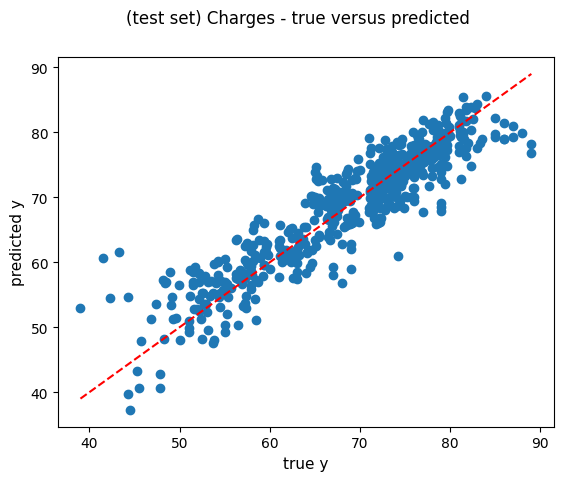

In [503]:
print('performance:')

y_true = df_rl['Life_expectancy'].values
y_pred = res.predict(df_rl.drop('Life_expectancy', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
train_rmse = np.sqrt(mse)
train_mape = mean_absolute_percentage_error(y_true, y_pred)

y_true = df_test['Life_expectancy'].values
y_pred = res.predict(df_test.drop('Life_expectancy', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
test_rmse = np.sqrt(mse)
test_mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'train RMSE: {train_rmse}, MAPE: {train_mape}')
print(f'test RMSE: {test_rmse}, MAPE: {test_mape}')

plt.scatter(x=y_true, y=y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')

plt.xlabel('true y', fontsize=11)
plt.ylabel('predicted y', fontsize=11)
plt.suptitle('(test set) Charges - true versus predicted')

plt.show()